2024-12-20 02:32:52.541214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734661972.558030  995994 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734661972.563244  995994 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 02:32:52.589979: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_995994/1595736817.py:10: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24

Train Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11363101 entries, 0 to 11363100
Data columns (total 84 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           object 
 1   Protocol           object 
 2   Timestamp          object 
 3   Flow Duration      object 
 4   Tot Fwd Pkts       object 
 5   Tot Bwd Pkts       object 
 6   TotLen Fwd Pkts    object 
 7   TotLen Bwd Pkts    object 
 8   Fwd Pkt Len Max    object 
 9   Fwd Pkt Len Min    object 
 10  Fwd Pkt Len Mean   object 
 11  Fwd Pkt Len Std    object 
 12  Bwd Pkt Len Max    object 
 13  Bwd Pkt Len Min    object 
 14  Bwd Pkt Len Mean   object 
 15  Bwd Pkt Len Std    object 
 16  Flow Byts/s        object 
 17  Flow Pkts/s        object 
 18  Flow IAT Mean      object 
 19  Flow IAT Std       object 
 20  Flow IAT Max       object 
 21  Flow IAT Min       object 
 22  Fwd IAT Tot        object 
 23  Fwd IAT Mean       object 
 24  Fwd IAT Std        object 
 25  F

/tmp/ipykernel_995994/299771055.py:46: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_features_categorical = train_features_categorical.applymap(str)



Encoding categorical features in train data...

Combined train features (before scaling):
    Dst Port  Protocol  Timestamp  Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  \
0      6568         2     195375        3605420          2101             0   
1     62291         2     127580        1952877          2101             0   
2     47019         1     154584        1991457             0             1   
3     37684         2     262296        1293246             0             1   
4     45723         2     239036        2752572          2765             1   

   TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  Fwd Pkt Len Min  ...  \
0                1                1                1                1  ...   
1                1                1                1                1  ...   
2            14094            13318             1653              357  ...   
3                1                1                1                1  ...   
4             9710                1        

/tmp/ipykernel_995994/299771055.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_features_categorical = val_features_categorical.applymap(str)



Encoding categorical features in validation data...

Combined validation features (before scaling):
    Dst Port  Protocol  Timestamp  Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  \
0     26127         2     136903         234886           575             0   
1     26309         2     111230        1006758          1113           762   
2     26127         2      63591        1011535           858             0   
3     48842         2      63055         937435           858           762   
4     35000         1     137319         642445           575             0   

   TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  Fwd Pkt Len Min  ...  \
0                1                1                1                1  ...   
1             5578             7272              518                1  ...   
2             9147                1             1190                1  ...   
3             2238            21857              617                1  ...   
4             6424               

/tmp/ipykernel_995994/299771055.py:97: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_features_categorical = test_features_categorical.applymap(str)



Encoding categorical features in test data...

Combined test features (before scaling):
    Dst Port  Protocol  Timestamp  Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  \
0     31366         2     170700         254582           577             0   
1     48736         2     145487         542601           577             0   
2     40786         2     212389         350991             0             1   
3     48736         2     145258         198244           577             0   
4     34299         1     101621        1030899             0             1   

   TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  Fwd Pkt Len Min  ...  \
0             2128                1             1865              272  ...   
1                1                1                1                1  ...   
2                1                1                1                1  ...   
3                1                1                1                1  ...   
4             6136             4765          

/tmp/ipykernel_995994/432265042.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


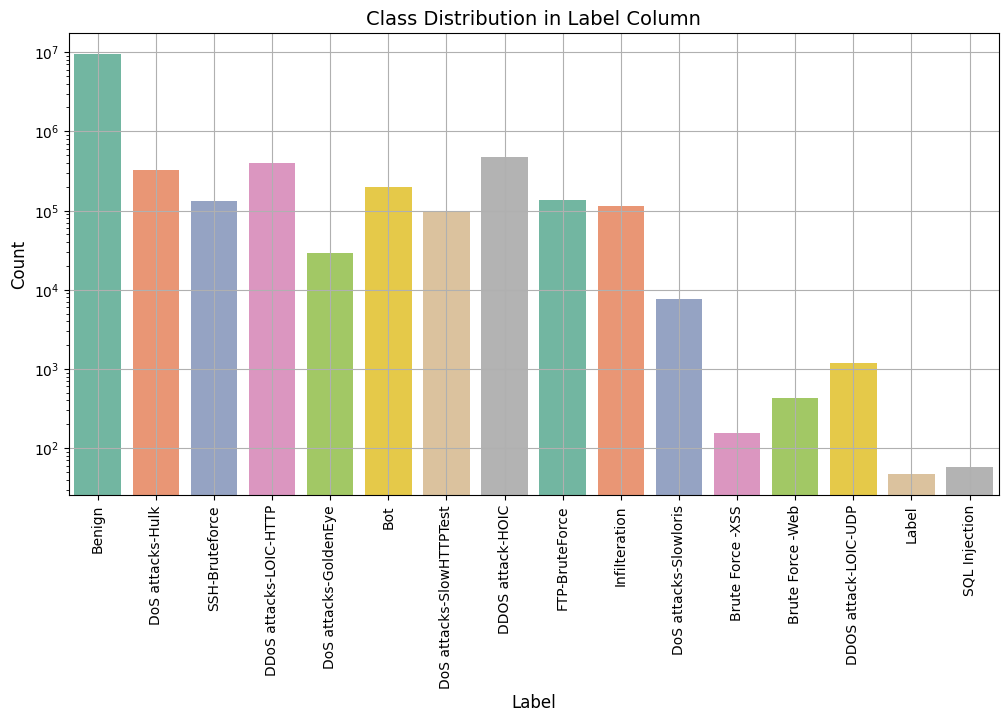

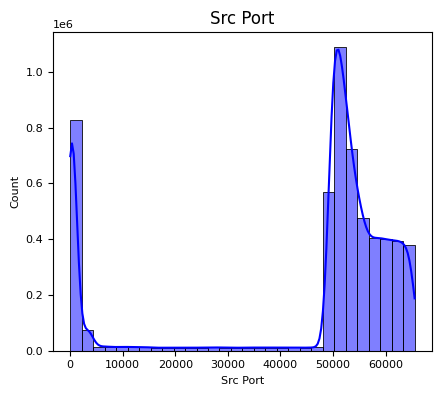

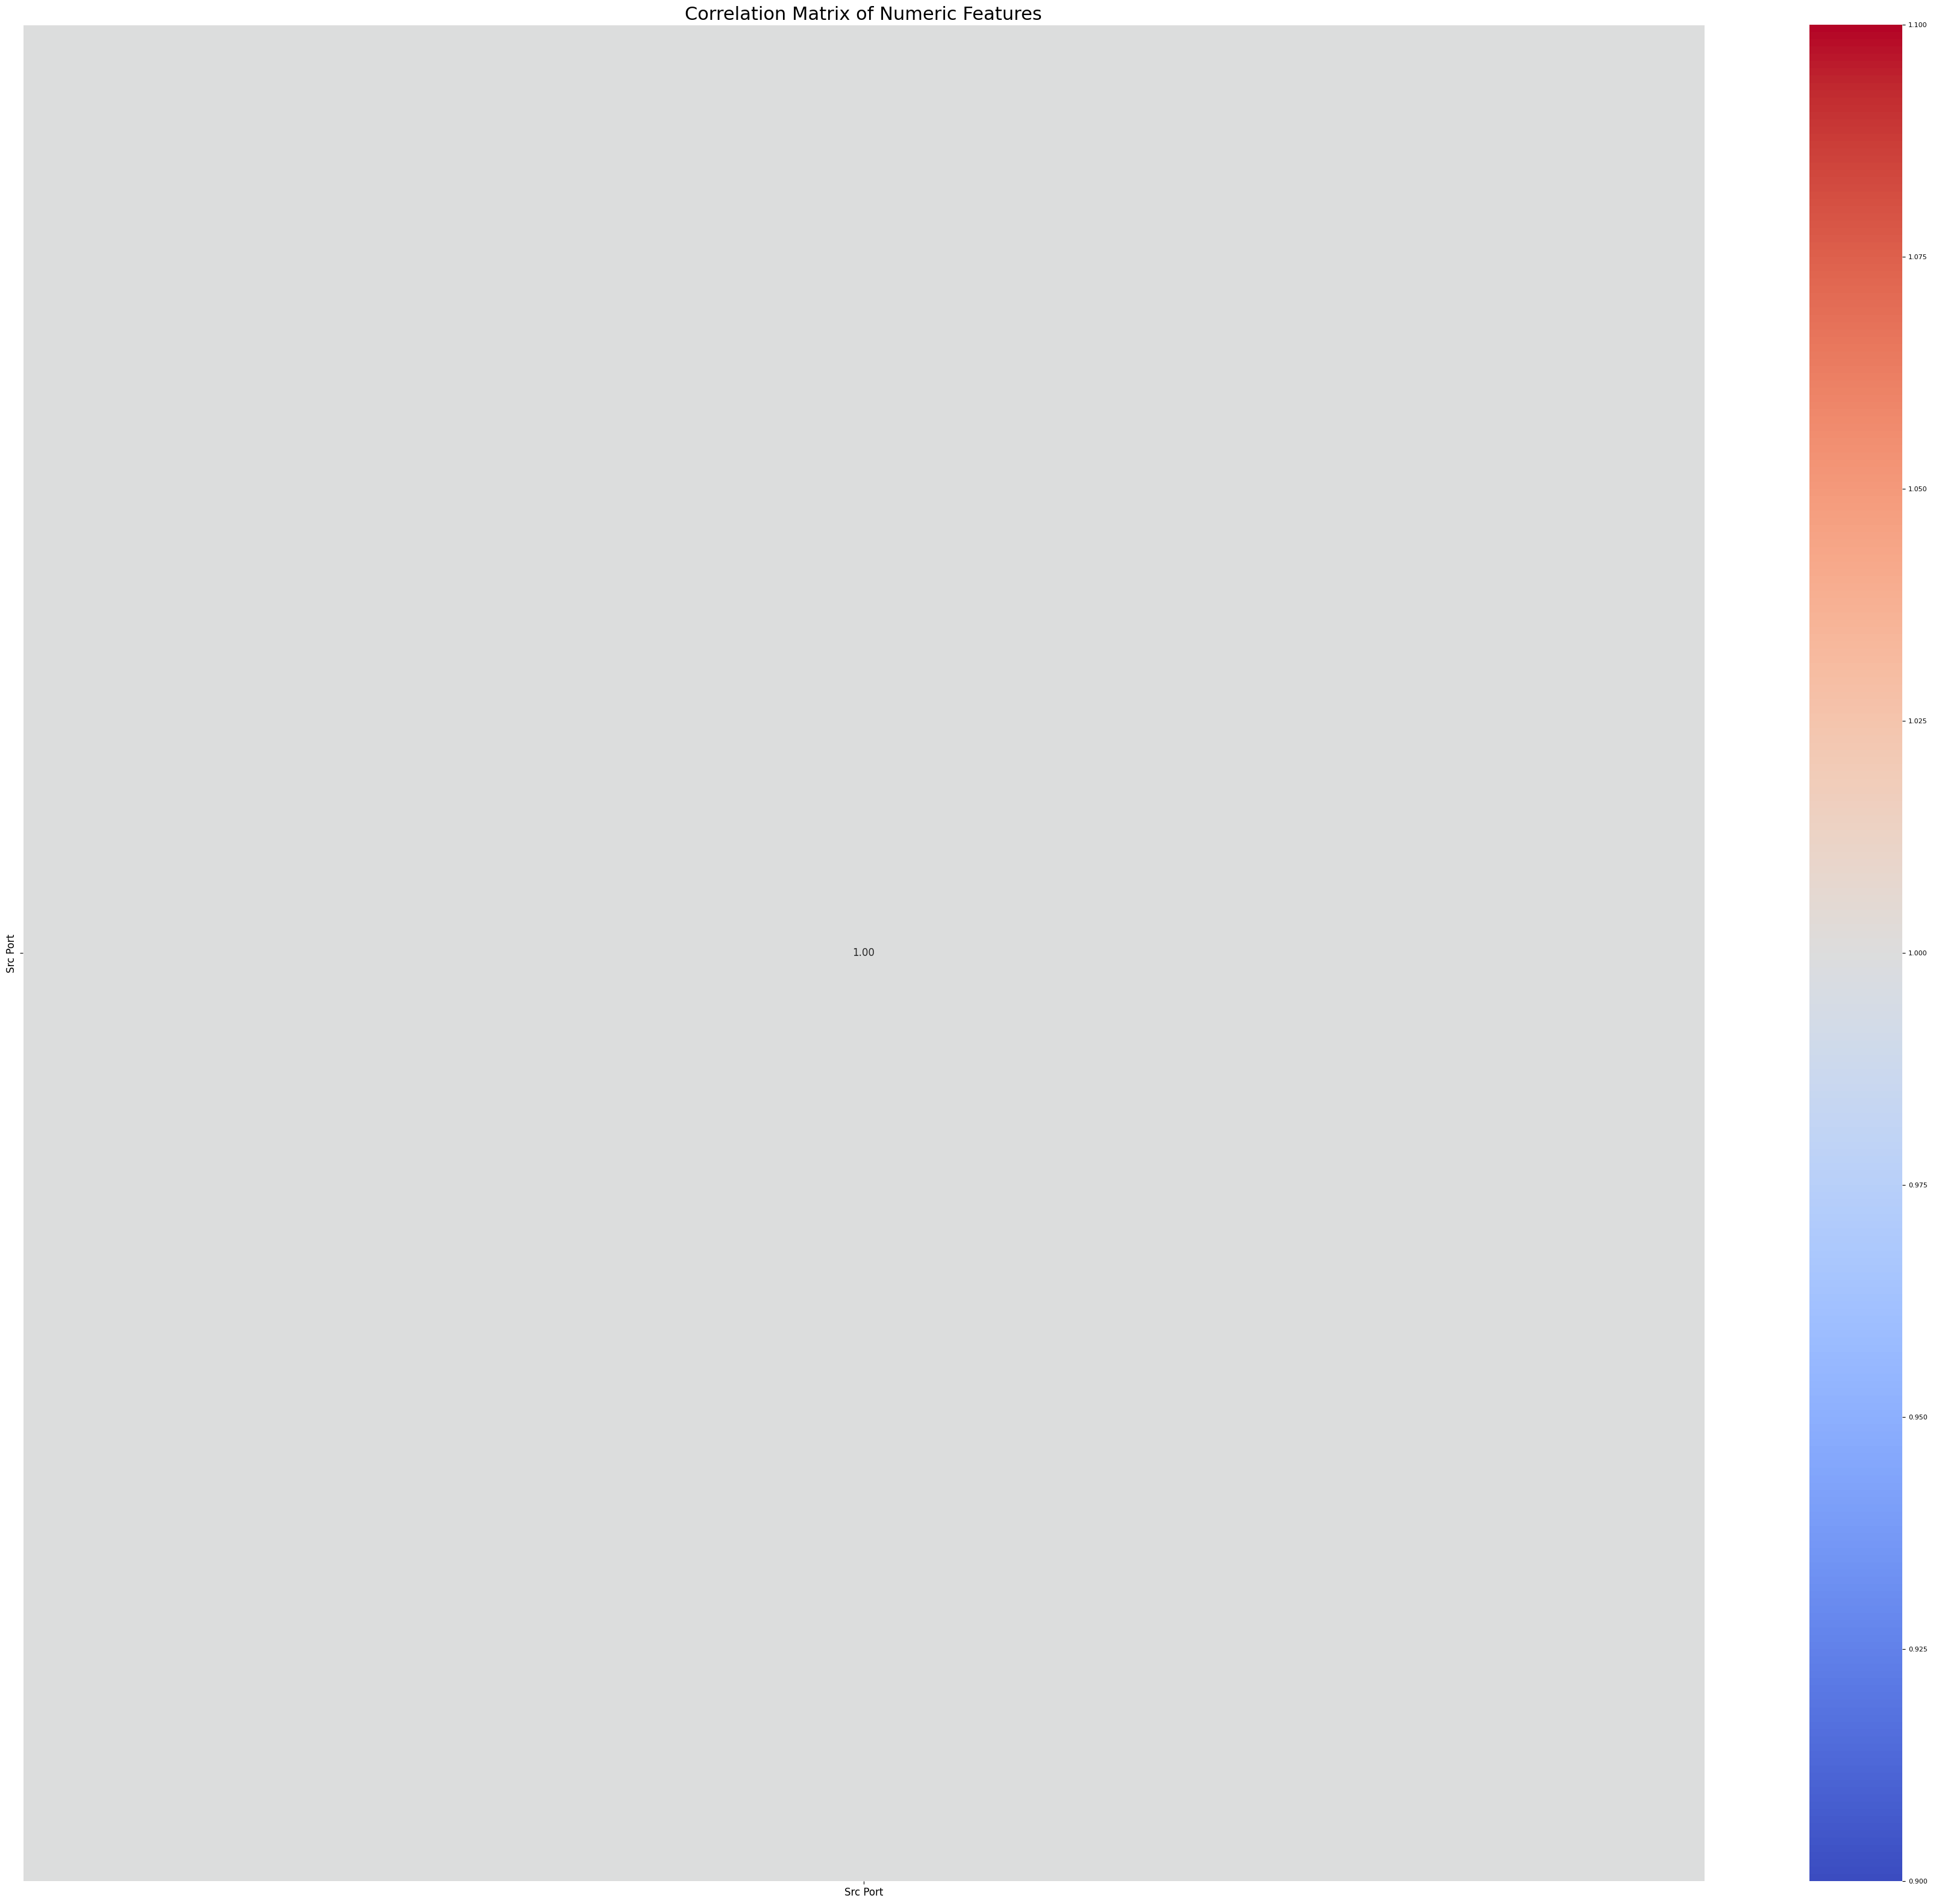

In [1]:
import import_ipynb
%run CICIDS_2018_data_preprocessing.ipynb


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class TimeNet(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=128, kernel_size=3, num_filters=64, dropout=0.5, dilation_rates=[1, 2, 4]):
        super(TimeNet, self).__init__()

        # Step 1: Temporal Convolutional Layers for feature extraction
        # Adjust padding to match the dilation
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=kernel_size, stride=1, padding=(dilation_rates[0] * (kernel_size - 1)) // 2, dilation=dilation_rates[0])  # Dilated convolution
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters * 2, kernel_size=kernel_size, stride=1, padding=(dilation_rates[1] * (kernel_size - 1)) // 2, dilation=dilation_rates[1])
        self.conv3 = nn.Conv1d(in_channels=num_filters * 2, out_channels=num_filters * 4, kernel_size=kernel_size, stride=1, padding=(dilation_rates[2] * (kernel_size - 1)) // 2, dilation=dilation_rates[2])

        # Step 2: Residual Connections (skip connections)
        self.residual1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=1, stride=1, padding=0)
        self.residual2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters * 2, kernel_size=1, stride=1, padding=0)
        self.residual3 = nn.Conv1d(in_channels=num_filters * 2, out_channels=num_filters * 4, kernel_size=1, stride=1, padding=0)

        # Step 3: Fully connected layers (for classification)
        self.fc1 = nn.Linear(num_filters * 4, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # Ensure input shape is [batch_size, channels, length]
        
        # Apply temporal convolution layers with residual connections
        res1 = self.residual1(x)  # Residual connection for the first layer
        x = self.conv1(x) + res1  # Adding residual to the convolution output
        x = torch.relu(x)
        
        res2 = self.residual2(x)  # Residual connection for the second layer
        x = self.conv2(x) + res2  # Adding residual to the convolution output
        x = torch.relu(x)
        
        res3 = self.residual3(x)  # Residual connection for the third layer
        x = self.conv3(x) + res3  # Adding residual to the convolution output
        x = torch.relu(x)

        # Step 3: Flatten the output for fully connected layers
        x = x.mean(dim=2)  # Global average pooling to reduce dimensionality (seq_len dimension)

        # Step 4: Use fully connected layers
        x = torch.relu(self.fc1(x))  # [batch_size, hidden_dim]
        x = self.dropout(x)
        x = self.fc2(x)  # [batch_size, num_classes]

        return x


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Define device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(X_train, y_train, X_val, y_val, X_test, y_test, labels, patience=5):
    num_classes = len(labels)
    input_dim = X_train.shape[1]
    model = TimeNet(input_dim=input_dim, num_classes=num_classes).to(device)  # Move model to device
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Add learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, threshold=1e-6, min_lr=1e-6)

    # Reshape the data for Conv1d (adding channel dimension)
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)  # Shape: (samples, 1, input_dim)
    X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train, torch.tensor(y_train, dtype=torch.long).to(device))
    val_dataset = TensorDataset(X_val, torch.tensor(y_val, dtype=torch.long).to(device))
    test_dataset = TensorDataset(X_test, torch.tensor(y_test, dtype=torch.long).to(device))

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Early stopping variables
    best_val_acc = 0.0
    epochs_without_improvement = 0
    best_model_weights = None

    # Training loop
    for epoch in range(100):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validate the model
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        val_accuracy = correct / total
        val_loss /= len(val_loader)

        # Step the scheduler based on validation accuracy
        scheduler.step(val_accuracy)

        print(f"Epoch {epoch + 1}, Loss: {running_loss:.6f}, Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.6f}, Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping check
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_weights = model.state_dict()  # Save the best model
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs with no improvement in validation accuracy.")
            break

    # Load the best model weights
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    # Evaluate on the test set
    model.eval()
    y_pred = []
    y_true = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(targets.tolist())
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    test_accuracy = correct / total

    # Print test set accuracy
    print(f"CICIDS_2018_TimeNet_accuracy: {test_accuracy:.6f}")

    return model, labels, y_true, y_pred


# Call the function
model, labels, y_test_true, y_test_pred = train_model(X_train, y_train, X_val, y_val, X_test, y_test, labels)


Epoch 1, Loss: 15303.497154, Validation Loss: 162.578522, Validation Accuracy: 0.830529, Learning Rate: 0.001000
Epoch 2, Loss: 25774.185987, Validation Loss: 927.729246, Validation Accuracy: 0.830529, Learning Rate: 0.001000
Epoch 3, Loss: 59651.498841, Validation Loss: 2484.890864, Validation Accuracy: 0.830529, Learning Rate: 0.001000
Epoch 4, Loss: 139195.773698, Validation Loss: 4675.222071, Validation Accuracy: 0.830529, Learning Rate: 0.001000
Epoch 5, Loss: 241386.776473, Validation Loss: 9732.303667, Validation Accuracy: 0.830529, Learning Rate: 0.000500
Epoch 6, Loss: 199768.000216, Validation Loss: 11258.402302, Validation Accuracy: 0.830529, Learning Rate: 0.000500
Early stopping triggered after 6 epochs with no improvement in validation accuracy.
CICIDS_2018_TimeNet_accuracy: 0.830809


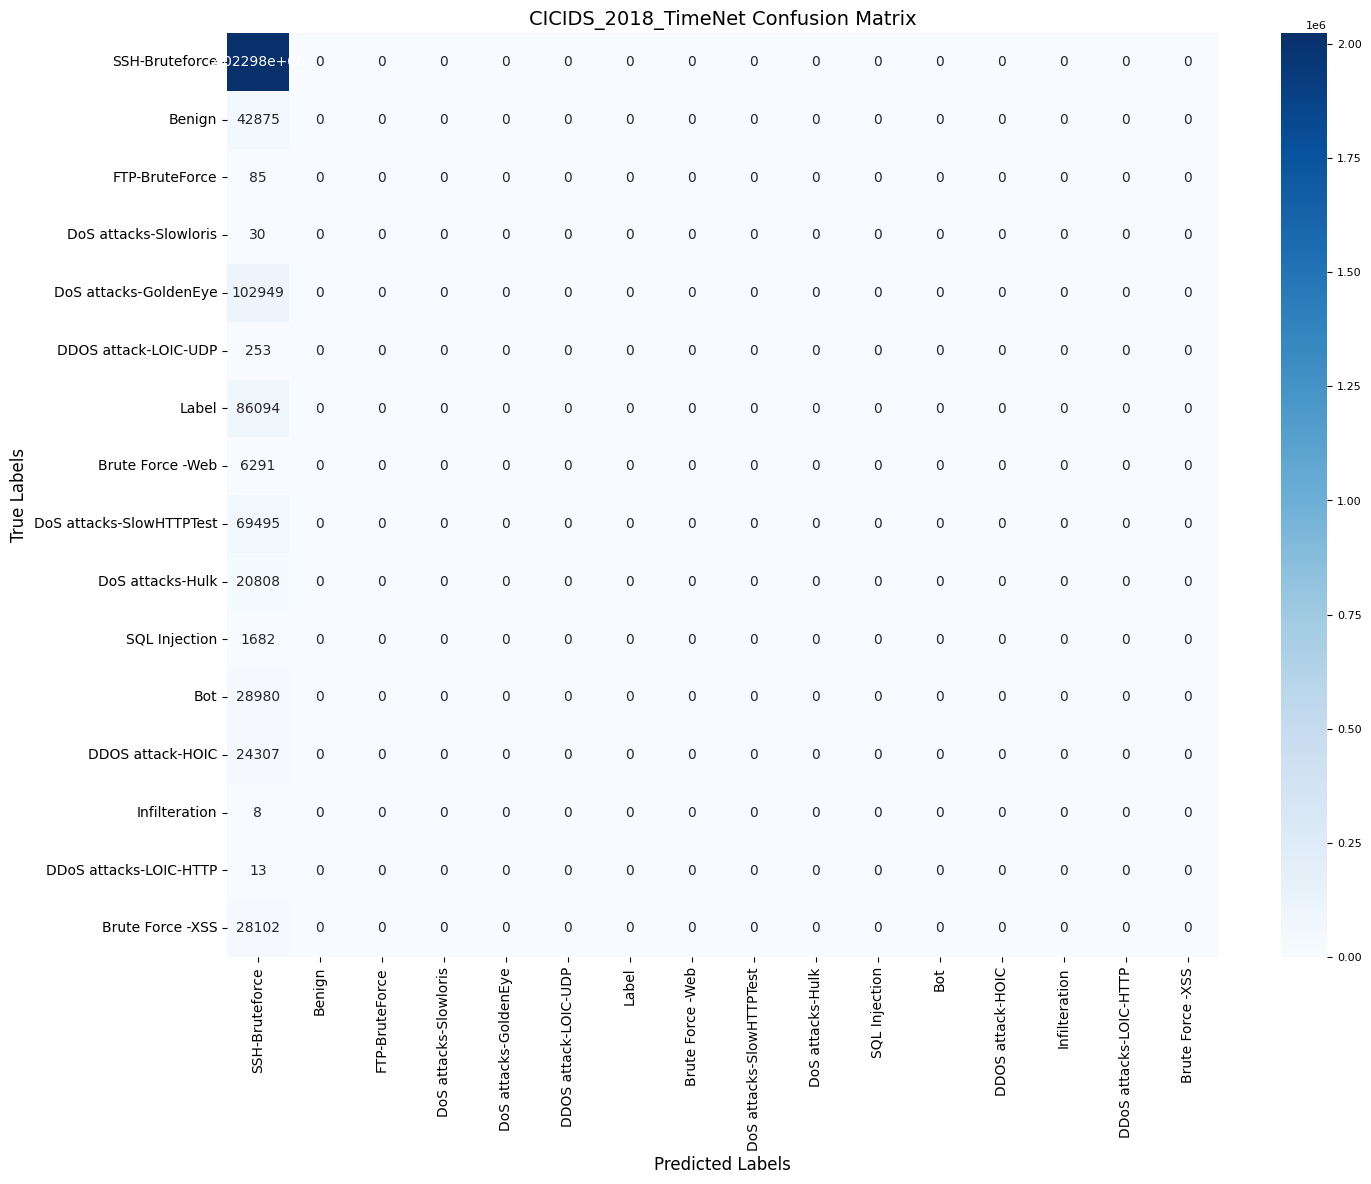

CICIDS_2018_TimeNet Classification Report:


/home/work/soyeong/alvy/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/work/soyeong/alvy/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          precision    recall  f1-score   support

          SSH-Bruteforce       0.83      1.00      0.91   2022979
                  Benign       0.00      0.00      0.00     42875
          FTP-BruteForce       0.00      0.00      0.00        85
   DoS attacks-Slowloris       0.00      0.00      0.00        30
   DoS attacks-GoldenEye       0.00      0.00      0.00    102949
    DDOS attack-LOIC-UDP       0.00      0.00      0.00       253
                   Label       0.00      0.00      0.00     86094
        Brute Force -Web       0.00      0.00      0.00      6291
DoS attacks-SlowHTTPTest       0.00      0.00      0.00     69495
        DoS attacks-Hulk       0.00      0.00      0.00     20808
           SQL Injection       0.00      0.00      0.00      1682
                     Bot       0.00      0.00      0.00     28980
        DDOS attack-HOIC       0.00      0.00      0.00     24307
           Infilteration       0.00      0.00      0.00         8
  DDoS at

/home/work/soyeong/alvy/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Plotting confusion matrix for Meta Model
cm_meta = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(16, 12))
sns.heatmap(cm_meta, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 10})
plt.title("CICIDS_2018_TimeNet Confusion Matrix", fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10) 
plt.show()

print("CICIDS_2018_TimeNet Classification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=labels))
